# Feature reduction and extraction


In this notebook we will extract features using deep learning method called Convultional autoencoder.

The input and the output to this method will be the galaxy images

---

let us call the data from the prevoius notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import numpy as np

2022-10-20 13:21:41.186734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 13:21:41.271342: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 13:21:41.289052: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 13:21:41.654303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

---

### call the data

In [2]:
from data_import.galaxy_mnist import GalaxyMNISTHighrez
dataset_train = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=True  # by default, or False for canonical test set
)
# for the testing data
dataset_test = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=False  # by default, or False for canonical test set
)

/home/ezraf/miniconda3/envs/galaxy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
images_train = dataset_train.data
images_test = dataset_test.data



In [4]:
labels_train = dataset_train.targets
labels_test = dataset_test.targets

In [5]:
class0 = np.where (np.array(labels_train) == 0 )
class1 = np.where (np.array(labels_train) == 1 )
class2 = np.where (np.array(labels_train) == 2 )
class3 = np.where (np.array(labels_train) == 3 )

In [6]:
labels_test

tensor([3, 2, 1,  ..., 0, 1, 1])

### pre-processing 

In [7]:
import torchvision.transforms as transforms

In [8]:
transformGrey = transforms.Grayscale()
images_trainGrey = transformGrey(images_train)
images_testGrey = transformGrey(images_test)

In [9]:
transformResize = transforms.Resize(56)

In [10]:
images_trainResized = transformResize(images_trainGrey)
images_testResized = transformResize(images_testGrey)

In [11]:
images_trainPre = images_trainResized/255
images_testPre = images_testResized/255

In [12]:
print(images_trainPre.shape)
print(images_testPre.shape)

torch.Size([8000, 1, 56, 56])
torch.Size([2000, 1, 56, 56])


In [13]:
images_trainPre = np.array(images_trainPre.reshape(8000,56,56))
images_testPre = np.array(images_testPre.reshape(2000,56,56))

In [14]:
images_trainPre.shape

(8000, 56, 56)

label: smooth_round
(56, 56)


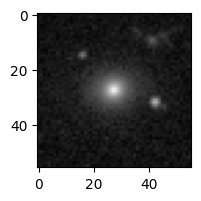

label: smooth_cigar
(56, 56)


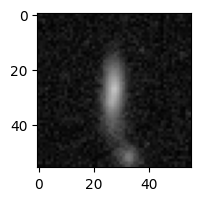

label: edge_on_disk
(56, 56)


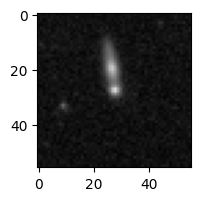

label: unbarred_spiral
(56, 56)


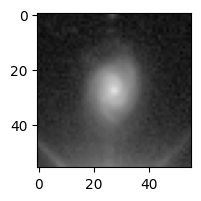

In [15]:
for classArr in [class0, class1, class2, class3]:
    train_image, train_label = dataset_train[classArr[0][0]]

    plt.figure(figsize=(2, 2))
    train_image = images_trainPre[classArr[0][0]]*255
    print("label: "+str(GalaxyMNISTHighrez.classes[train_label]))
    print(train_image.shape)
    plt.imshow(train_image,cmap='gray', vmin=0, vmax=255 )
    plt.show() 

---

### train

In [16]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(56*56, activation='sigmoid'),
      layers.Reshape((56, 56))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

2022-10-20 13:21:45.041938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 13:21:45.044632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 13:21:45.044724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 13:21:45.045327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [17]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [18]:
autoencoder.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=50,
                shuffle=True,
                validation_data=(np.array(images_testPre), np.array(images_testPre)))

Epoch 1/50
144/250 [================>.............] - ETA: 0s - loss: 0.0186

2022-10-20 13:21:46.702535: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


250/250 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0052
Epoch 2/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 3/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 4/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 6/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/50
250/250 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 11/5

In [19]:
encoded_imgs = autoencoder.encoder(images_testPre).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [20]:
print(images_testResized.shape)
print(decoded_imgs.shape)

torch.Size([2000, 1, 56, 56])
(2000, 56, 56)


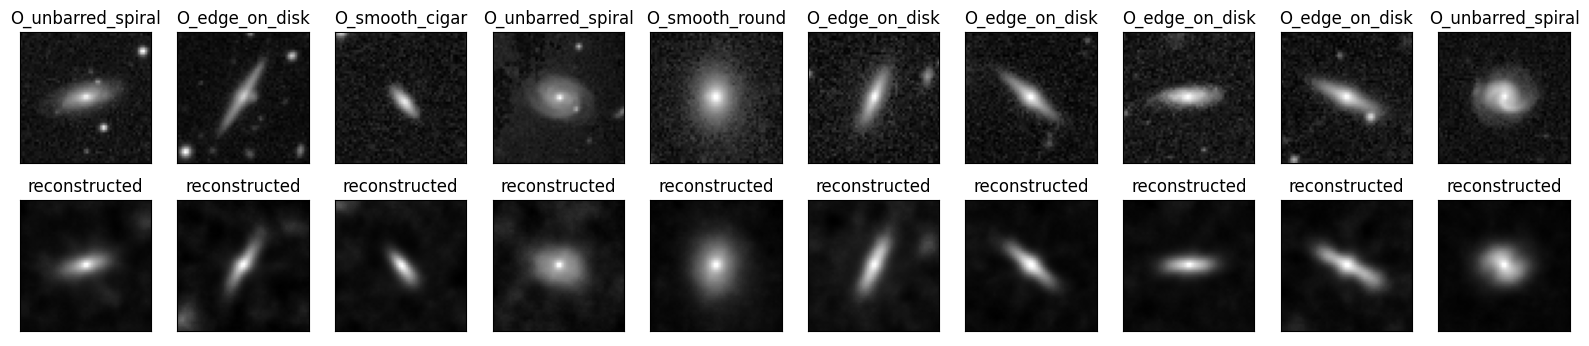

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images_testPre[i])
  plt.title("O_"+str(GalaxyMNISTHighrez.classes[np.array(labels_test[i])] ))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

- one thing to notice is that the details for the spiral galaxy is gone, and it looks more like the smooth round one

---

### fit the other model

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

class GalaxyEncoder(Model):
    def __init__(self):
        super(GalaxyEncoder, self).__init__()
        self.encoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(56,56,1)),
            layers.Conv2D(16, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(8, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Flatten()
        ])
        self.decoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(1568)),
            layers.Reshape((14, 14, 8)),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(8, (3,3), 1, padding="same", activation="relu"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(16, (3,3), 1, padding="same", activation="relu"),
            layers.Conv2D(1, (3,3), 1, padding="same", activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [29]:
# from source.galaxyencode import GalaxyEncoder

In [30]:
model = GalaxyEncoder()

In [31]:
model.compile(optimizer='sgd', loss='mse')


In [32]:
model.build((None,56,56))
model.summary()

Model: "galaxy_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 1568)              1320      
                                                                 
 sequential_5 (Sequential)   (None, 56, 56, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=50,
                shuffle=True,
                validation_data=(np.array(images_testPre), np.array(images_testPre)))

Epoch 1/50


2022-10-20 13:22:49.631947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


  1/250 [..............................] - ETA: 5:32 - loss: 0.1651

2022-10-20 13:22:50.186305: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-20 13:22:50.186724: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-20 13:22:50.186744: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-20 13:22:50.187124: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-20 13:22:50.187149: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


250/250 [==============================] - 2s 4ms/step - loss: 0.0770 - val_loss: 0.0170
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 8/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 9/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 11/5

In [34]:
encoded_imgs = model.encoder(images_testPre).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

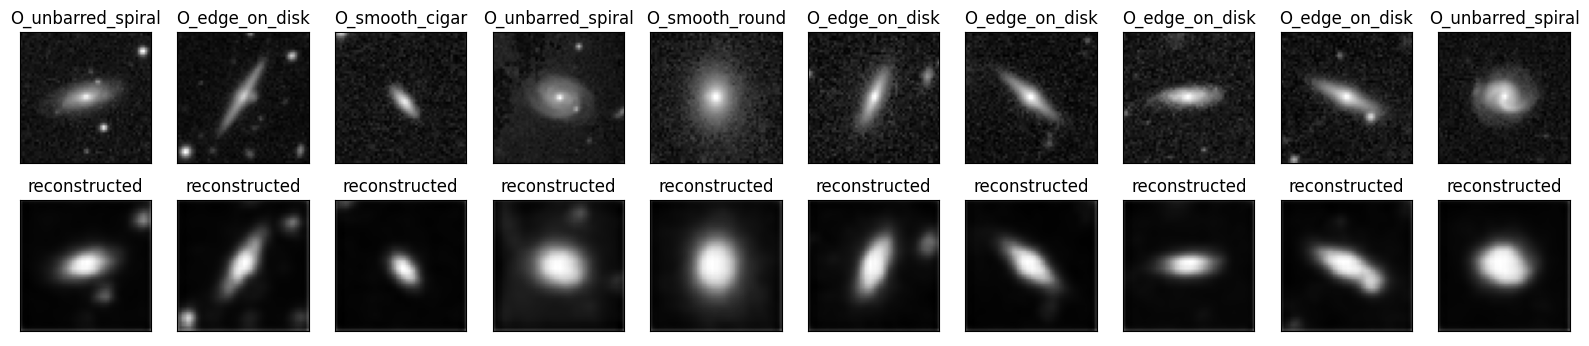

In [35]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images_testPre[i])
  plt.title("O_"+str(GalaxyMNISTHighrez.classes[np.array(labels_test[i])] ))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()